In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/4-Model_Setup.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/4-Model_Setup.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/4-Model_Setup.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes reference data from the TimeSync image interpretation tool, extracts the values from the LandTrendr and CCDC outputs from the previous notebooks, and introduces some tricks and tips working with statistical models inside and outside GEE


### Objective

In this tutorial, you learn how to set up LCMS models and evaluate model error

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in TimeSync data
- Creating terrain predictors
- Extracting LandTrendr, CCDC, and terrain values for TimeSync plot locations
- Training LCMS models and looking at error

In [2]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p
import inspect,operator
import matplotlib.pyplot as plt
import pandas as pd  
# from IPython.display import IFrame,display, HTML
ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Initializing GEE
Successfully initialized
geeViz package folder: /opt/conda/lib/python3.10/site-packages/geeViz
PyTables is not installed. No support for HDF output.
Done


## Before you begin

### Set your current URL under `workbench_url`
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/`

### Set a folder to use for all exports under `export_path_root` 
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [3]:
workbench_url = 'https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/'
export_path_root  = 'projects/rcr-gee/assets/lcms-training'

print('Done')

Done


In [4]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_composite_collection = f'{export_path_root}/lcms-training_module-2_composites'
export_landTrendr_collection = f'{export_path_root}/lcms-training_module-3_landTrendr'
export_ccdc_collection = f'{export_path_root}/lcms-training_module-3_CCDC'

export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/lcms-292214/assets/R8/PR_USVI/TimeSync/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC'


aml.create_asset(export_timeSync_folder)

# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Found the following sub directories:  ['lcms-training', 'lcms-training_module-4_timeSync']
Will attempt to create them if they do not exist
Asset projects/rcr-gee/assets/lcms-training already exists
Asset projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync already exists
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [5]:
Map.proxy_url = workbench_url
# First, let's bring in TimeSync and set up some parameters
# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None

# Bring in annualized TimeSync data
# Each plot has one feature for each year from 2000 to 2020
# This results in over 20k plots
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
training_years = [int(yr) for yr in timeSyncData.aggregate_histogram('YEAR').keys().getInfo()]
plot_ids = timeSyncData.aggregate_histogram('PLOTID').keys().getInfo()
print('Training years:',training_years)
print('Unique Plot ID Count:',len(plot_ids))
print('Total Training Plots:', timeSyncData.size().getInfo())
print('TimeSync Attributes:',timeSyncData.first().propertyNames().getInfo())

print('Done')

Training years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Unique Plot ID Count: 1000
Total Training Plots: 20992
TimeSync Attributes: ['DOM_LU', 'GRASS-TS', 'latitude', 'JULIANDAY', 'COMMENTS', 'BARREN-IMP', 'SEC_LC', 'SHRUBS-TRE', 'INTERP', 'YEAR', 'SHRUBS', 'X', 'GRASS', 'Y', 'SEC_LU', 'SEC_LU_EL', 'DOM_SEC_LC', 'BARREN-GRA', 'DOM_LU_EL', 'IMPERVIOUS', 'WATER', 'longitude', 'CP_NOTES', 'SNOW', 'BARREN-TS', 'GRASS-TREE', 'PLOTID', 'CP', 'LAST_MODIF', 'BARREN-TRE', 'GRASS-SHRU', 'PACKET_ID', 'BARREN', 'DOM_LC', 'TREES', 'BARREN-SHR', 'CHANGE_DUR', 'SHRUBS-TS', 'system:index', 'TS-TREES', 'TS']
Done


In [121]:
Map.clearMap()

# Let's view the TimeSync data
# This will zoom to the first plot in the featureCollection
# Find a plot (they're 30m x 30m - small), and double-click on it to see 
# that there are actually multiple plots at that location - 1 for each year
Map.addLayer(timeSyncData.map(lambda f:f.buffer(15).bounds(5,crs)),{'layerType':'geeVectorImage'},'LCMS PRUSVI TimeSync Training Data')
Map.turnOnInspector()
Map.centerObject(timeSyncData.first())
Map.view()

Adding layer: LCMS PRUSVI TimeSync Training Data
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/?accessToken=None HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/css/style.min.css HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/js/gena-gee-palettes.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/js/load.min.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/js/lcms-viewer.min.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/images/GEE.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/images/usfslogo.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/images/usdalogo.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/images/layer_icon.png HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeView/images/logos_usda-fs.svg HTTP/1.1" 200 -
127.0.0.1 - - [08/Aug/2023 19:20:37] "GET /geeVi

In [6]:
# The TimeSync data has the reference classes, but lacks the predictor variables
# We will now set up annual LandTrendr and CCDC outputs from our raw exported assets


# First, we will bring in LandTrendr data for each year

landTrendrCollection = ee.ImageCollection(export_landTrendr_collection)

landTrendrCollectionInfo = landTrendrCollection.first().toDictionary().getInfo()

Map.clearMap()

# View exported LT output
# Convert stacked outputs into collection of fitted, magnitude, slope, duration, etc values for each year
# While the fitted LandTrendr value is generally of most importance to our models, 
# LandTrendr segment duration, slope, and magnitude of change can also help our models
lt_fit = changeDetectionLib.batchSimpleLTFit(landTrendrCollection,landTrendrCollectionInfo['startYear'],landTrendrCollectionInfo['endYear'],None,bandPropertyName='band',arrayMode=True)

# Vizualize image collection for charting (opacity set to 0 so it will chart but not be visible)
Map.addLayer(lt_fit,{'bands':'swir2_LT_fitted,nir_LT_fitted,red_LT_fitted','min':0.15,'max':0.6},'LandTrendr All Predictors Time Series')

# Visualize fitted landTrendr composites
fitted_bns = lt_fit.select(['.*_fitted']).first().bandNames()
out_bns = fitted_bns.map(lambda bn: ee.String(bn).split('_').get(0))

# Give same names as composites
lt_synth = lt_fit.select(fitted_bns,out_bns)

# Visualize LandTrendr fitted 
Map.addTimeLapse(lt_synth,getImagesLib.vizParamsFalse,'Fitted LandTrendr Composite Timelapse')


Map.centerObject(landTrendrCollection.first())
Map.turnOnInspector()
Map.view()

Adding layer: LandTrendr All Predictors Time Series
Adding layer: Fitted LandTrendr Composite Timelapse
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Starting local web server at: http://localhost:1234/geeView/
HTTP server command: "/opt/conda/bin/python" -m http.server  1234
Done
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [08/Aug/2023 19:44:58] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [7]:
# And then bring in CCDC data for each year
Map.clearMap()

ccdcTiles = ee.ImageCollection(export_ccdc_collection)
composites = ee.ImageCollection(export_composite_collection)
ccdcInfo = ccdcTiles.first().toDictionary().getInfo()
print(ccdcInfo)
startYear = 1984
endYear = 2023
startJulian = 1
endJulian = 365

ccdcImg = ccdcTiles.mosaic()
#Specify which harmonics to use when predicting the CCDC model
#CCDC exports the first 3 harmonics (1 cycle/yr, 2 cycles/yr, and 3 cycles/yr)
#If you only want to see yearly patterns, specify [1]
#If you would like a tighter fit in the predicted value, include the second or third harmonic as well [1,2,3]
whichHarmonics = [1,2,3]

#Whether to fill gaps between segments' end year and the subsequent start year to the break date
fillGaps = False

# Proportion of a year segment can be extrapolated
# This can be important if the CCDC run had a break toward the end of the available raw data, but has not fit a 
# new model. This would introduce a null value past that break date if set to 0
# By setting to e.g. 0.3, a segment at the end can be extended by 0.3 of a year before it will result in a null value
tEndExtrapolationPeriod = 0.3


# If annualizeWithCompositeDates = False, this month and day will be used as the time to pull CCDC values
yearStartMonth = 4
yearStartDay = 1


# When annualizing CCDC outputs, we can pull the CCDC fitted, harmonic model coefficients, 
# and fitted difference from the previous year using a set date (e.g. April 1) or we can use the date from within our annual
# composites to increase the chance the CCDC output matches the timing of the composite values used within
# LandTrendr. In this example, we can bring in the annual composites and pull the dates for annualizing CCDC 
# by setting annualizeWithCompositeDates = True
# This will slow down computing, so you can set it to False for testing runs
annualizeWithCompositeDates = False
compositeCollection = composites

annualSegCoeffs = changeDetectionLib.annualizeCCDC(ccdcImg, startYear, endYear, startJulian, endJulian, tEndExtrapolationPeriod, 
  yearStartMonth, yearStartDay, annualizeWithCompositeDates, compositeCollection)
annualCCDC = changeDetectionLib.getFitSlopeCCDC(annualSegCoeffs, startYear, endYear)
ccdc_bandNames = annualCCDC.first().bandNames()
ccdc_bandNames = ccdc_bandNames.removeAll(['year'])
print('Available CCDC Predictor Variables:',ccdc_bandNames.getInfo())

# Visualize output as you would a composite
Map.addLayer(annualCCDC.select(ccdc_bandNames),{'bands':'swir1_predicted,nir_predicted,red_predicted','min':0.05,'max':0.6},'Annual CCDC Output')
Map.addLayer(annualCCDC.select(['year']),{},'CCDC Annualizing Time Input',False)
Map.turnOnInspector()
Map.view()


{'TileID': '90,54', 'TileSize': 60000}
Available CCDC Predictor Variables: ['blue_CCDC_INTP', 'blue_CCDC_SLP', 'blue_CCDC_COS1', 'blue_CCDC_SIN1', 'blue_CCDC_COS2', 'blue_CCDC_SIN2', 'blue_CCDC_COS3', 'blue_CCDC_SIN3', 'green_CCDC_INTP', 'green_CCDC_SLP', 'green_CCDC_COS1', 'green_CCDC_SIN1', 'green_CCDC_COS2', 'green_CCDC_SIN2', 'green_CCDC_COS3', 'green_CCDC_SIN3', 'red_CCDC_INTP', 'red_CCDC_SLP', 'red_CCDC_COS1', 'red_CCDC_SIN1', 'red_CCDC_COS2', 'red_CCDC_SIN2', 'red_CCDC_COS3', 'red_CCDC_SIN3', 'nir_CCDC_INTP', 'nir_CCDC_SLP', 'nir_CCDC_COS1', 'nir_CCDC_SIN1', 'nir_CCDC_COS2', 'nir_CCDC_SIN2', 'nir_CCDC_COS3', 'nir_CCDC_SIN3', 'swir1_CCDC_INTP', 'swir1_CCDC_SLP', 'swir1_CCDC_COS1', 'swir1_CCDC_SIN1', 'swir1_CCDC_COS2', 'swir1_CCDC_SIN2', 'swir1_CCDC_COS3', 'swir1_CCDC_SIN3', 'swir2_CCDC_INTP', 'swir2_CCDC_SLP', 'swir2_CCDC_COS1', 'swir2_CCDC_SIN1', 'swir2_CCDC_COS2', 'swir2_CCDC_SIN2', 'swir2_CCDC_COS3', 'swir2_CCDC_SIN3', 'NDVI_CCDC_INTP', 'NDVI_CCDC_SLP', 'NDVI_CCDC_COS1', 'NDVI

127.0.0.1 - - [08/Aug/2023 19:45:23] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [10]:
# LCMS also uses various elevation/terrain variables to help our models
Map.clearMap()
terrainStack = []

# Can use any elevation data
# Will use SRTM for this example
# Resampling must be set to bicubic or bilinear or there will be artifacts in terrain derivatives
elevation = ee.Image("USGS/SRTMGL1_003").resample('bicubic')
aspect = ee.Terrain.aspect(elevation)
sinAspect = aspect.sin().rename('sinAspect')
cosAspect = aspect.cos().rename('cosAspect')

terrainStack.extend([sinAspect,cosAspect])

# A very simple algorithm for elevation position
# Good at finding ridges and depressions
def tpi(elevation,n):
    return elevation.subtract(elevation.focalMean(n)).rename([f'TPI_{int(n*2)}'])

# A nice palette from: https://github.com/gee-community/ee-palettes
# Use cmocean.speed[7]
palette = ['fffdcd', 'e1cd73', 'aaac20', '5f920c', '187328', '144b2a', '172313']

Map.addLayer(elevation.reproject(crs,transform),{'min':0,'max':250,'palette':palette},'Elevation')

# Get TPI for 11 and 21 pixel diameter circular kernels
for r in [5.5,10.5,20.5]:
    tpiR = tpi(elevation,r)
    terrainStack.append(tpiR)
    Map.addLayer(tpiR.reproject(crs,transform),{'min':-10,'max':10,'palette':palette},f'TPI {int(r*2)}')

# Stack all terrain data
terrainStack = ee.Image.cat(terrainStack)
print('Available terrain bands:',terrainStack.bandNames().getInfo())
Map.view()

Adding layer: Elevation
Adding layer: TPI 11
Adding layer: TPI 21
Adding layer: TPI 41
Available terrain bands: ['sinAspect', 'cosAspect', 'TPI_11', 'TPI_21', 'TPI_41']
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [08/Aug/2023 19:47:31] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [12]:
# Now extract LandTrendr, CCDC, and terrain values for each TimeSync plot from its respective year

# First, set up a function that will get all predictors for a given year
def getPredictorStack(yr):
     # Filter the LandTrendr and CCDC data for the given year
    lt_yr = lt_fit.filter(ee.Filter.calendarRange(yr,yr,'year')).first()
    ccdc_yr = annualCCDC.filter(ee.Filter.calendarRange(yr,yr,'year')).first()

    # Get a stack of all predictor bands
    extractionStack = ee.Image.cat([lt_yr,ccdc_yr,terrainStack])
    return extractionStack.set('system:time_start',ee.Date.fromYMD(yr,6,1).millis())

# Find the currently running tasks so we can check to see if something is already running or ready to run
currently_running_tasks =  tml.getTasks()

# Whether to overwrite existing tables
overwrite = True

# Extract for each year
for training_year in training_years:
    
    # Filter TimeSync data for the given year
    timeSyncData_yr = timeSyncData.filter(ee.Filter.eq('YEAR',training_year))
   
    # Get the predictor variables for the year
    extractionStack = getPredictorStack(training_year)
    
    # Extract the values
    extracted_values = extractionStack.reduceRegions(collection=timeSyncData_yr, reducer = ee.Reducer.first(), scale = None, crs = crs, crsTransform = transform, tileScale = 4)
    
    # Export them as an asset
    assetName = f'LCMS_Training_TimeSync_yr{training_year}_LandTrendr_CCDC_Terrain_Extraction'
    assetPath = f'{export_timeSync_folder}/{assetName}'
    
    currently_exporting = assetName in tml.getTasks()['running'] or assetName in tml.getTasks()['ready'] 
    currently_exists = aml.ee_asset_exists(assetPath)

    if overwrite and currently_exists:
        ee.data.deleteAsset(assetPath)
    if overwrite and currently_exporting:
        tml.cancelByName(assetName)
        
    # Export if it doesn't exist or isn't being run already
    if overwrite or (not currently_exists and not currently_exporting):
        t = ee.batch.Export.table.toAsset(collection = extracted_values,
                          description = assetName,
                          assetId = assetPath)
        print('Exporting:',assetName)
        print(t)
        t.start()
    else:
        print(f'{assetName} already exists or is currently being exported')


Exporting: LCMS_Training_TimeSync_yr2000_LandTrendr_CCDC_Terrain_Extraction
<Task EXPORT_FEATURES: LCMS_Training_TimeSync_yr2000_LandTrendr_CCDC_Terrain_Extraction (UNSUBMITTED)>
Exporting: LCMS_Training_TimeSync_yr2001_LandTrendr_CCDC_Terrain_Extraction
<Task EXPORT_FEATURES: LCMS_Training_TimeSync_yr2001_LandTrendr_CCDC_Terrain_Extraction (UNSUBMITTED)>
Exporting: LCMS_Training_TimeSync_yr2002_LandTrendr_CCDC_Terrain_Extraction
<Task EXPORT_FEATURES: LCMS_Training_TimeSync_yr2002_LandTrendr_CCDC_Terrain_Extraction (UNSUBMITTED)>
Exporting: LCMS_Training_TimeSync_yr2003_LandTrendr_CCDC_Terrain_Extraction
<Task EXPORT_FEATURES: LCMS_Training_TimeSync_yr2003_LandTrendr_CCDC_Terrain_Extraction (UNSUBMITTED)>
Exporting: LCMS_Training_TimeSync_yr2004_LandTrendr_CCDC_Terrain_Extraction
<Task EXPORT_FEATURES: LCMS_Training_TimeSync_yr2004_LandTrendr_CCDC_Terrain_Extraction (UNSUBMITTED)>
Exporting: LCMS_Training_TimeSync_yr2005_LandTrendr_CCDC_Terrain_Extraction
<Task EXPORT_FEATURES: LCMS_T

In [ ]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
# tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(export_timeSync_folder, type = 'tables')

print('done')

In [59]:
# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimsSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
predictor_field_names = extractionStack.bandNames().getInfo()

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))
print('Training data first plot:',training_data.first().getInfo())



Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2000_LandTrendr_CCDC_Terrain_Extraction
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2001_LandTrendr_CCDC_Terrain_Extraction
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2002_LandTrendr_CCDC_Terrain_Extraction
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2003_LandTrendr_CCDC_Terrain_Extraction
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2004_LandTrendr_CCDC_Terrain_Extraction
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync/LCMS_Training_TimeSync_yr2005_LandTrendr_CCDC_Terrain_Extraction
Updating permissions for:  p

In [60]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'BARREN-IMP':12,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
    # print(name_fieldName,code_fieldName.getInfo(),name.getInfo(),code.getInfo())
            
# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print(product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

print('Converted codes:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())
print(training_data.aggregate_histogram('CP').getInfo())

Land_Cover
Land_Use
Change
Converted codes: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Forest', 'DOM_LU_Code': 3, 'DOM_SEC_LC': 'BARREN-TRE', 'DOM_SEC_LC_Code': 5}
{'Debris': 6, 'Fire': 3, 'Growth/Recovery': 2501, 'Harvest': 88, 'Hydrology': 67, 'Mechanical': 197, 'Other': 10, 'Spectral Decline': 30, 'Stable': 17543, 'Structural Decline': 2, 'Wind/Ice': 543}


In [ ]:
# Now, we'll explore the 


Getting model info for All Predictors Land Cover
All Predictors Land Cover OOB Accuracy: 0.9756074321105288


,Trees,Tall Shrubs & Trees Mix (SEAK Only),Shrubs & Trees Mix,Grass/Forb/Herb & Trees Mix,Barren & Trees Mix,Tall Shrubs (SEAK Only),Shrubs,Grass/Forb/Herb & Shrubs Mix,Barren & Shrubs Mix,Grass/Forb/Herb,Barren & Grass/Forb/Herb Mix,Barren or Impervious,Snow or Ice,Water,Producers Accuracy (1 - omission error)
Trees,12098,0,0,0,0,0,0,0,0,0,0,1,0,0,99
Tall Shrubs & Trees Mix (SEAK Only),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Shrubs & Trees Mix,13,0,750,0,0,0,1,0,0,0,0,0,0,0,98
Grass/Forb/Herb & Trees Mix,8,0,0,1103,0,0,0,0,0,0,0,0,0,0,99
Barren & Trees Mix,3,0,0,0,44,0,0,0,0,0,0,0,0,0,93
Tall Shrubs (SEAK Only),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Shrubs,2,0,1,0,0,0,829,0,0,0,0,0,0,0,99
Grass/Forb/Herb & Shrubs Mix,0,0,1,0,0,0,3,871,0,2,0,0,0,0,99
Barren & Shrubs Mix,0,0,0,0,0,0,1,0,107,0,0,0,0,0,99
Grass/Forb/Herb,0,0,0,0,0,0,0,5,0,2340,0,1,0,0,99


Adding layer: All Predictors Land Cover 2017
Getting model info for All Predictors Land Use
All Predictors Land Use OOB Accuracy: 0.9937112910909958


,Agriculture,Developed,Forest,Non-Forest Wetland,Other,Rangeland or Pasture,Producers Accuracy (1 - omission error)
Agriculture,636,0,0,0,0,0,100
Developed,0,3810,0,0,0,0,100
Forest,0,0,11823,0,0,0,100
Non-Forest Wetland,0,0,1,998,0,0,99
Other,0,0,0,0,815,0,100
Rangeland or Pasture,0,0,0,0,0,2907,100
Consumers Accuracy (1 - commission error),100,100,99,100,100,100,99


Adding layer: All Predictors Land Use 2017
Getting model info for All Predictors Change
All Predictors Change OOB Accuracy: 0.920819437827537


,Stable,Slow Loss,Fast Loss,Gain,Producers Accuracy (1 - omission error)
Stable,17541,0,1,1,99
Slow Loss,1,30,0,1,93
Fast Loss,54,0,853,7,93
Gain,36,0,1,2464,98
Consumers Accuracy (1 - commission error),99,100,99,99,99


Adding layer: All Predictors Change 2017
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


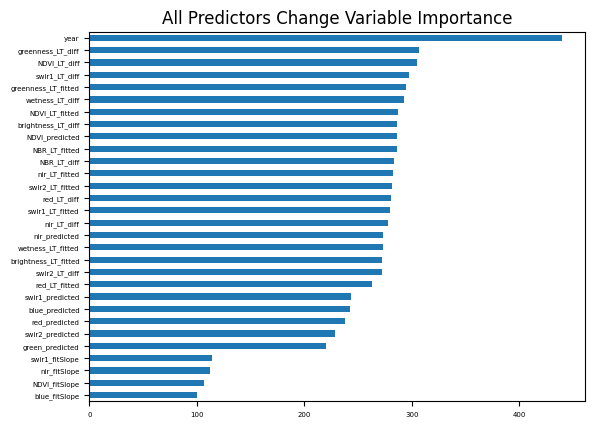

127.0.0.1 - - [09/Aug/2023 17:39:15] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -
127.0.0.1 - - [09/Aug/2023 17:47:24] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [65]:
Map.clearMap()
# Not let's train and apply a RandomForest model for Land Cover

# Set some parameters
nTrees = 50 # Number of trees to use in the Random Forest model. > 50 can result in memory errors and generally doesn't help the model much
seed = 999 # Set a seed to ensure the same model is recreated with each run. Change this if a new one is needed
top_n_variables = 30 # Take this number of variables into the final model
apply_year = 2017 # Year to apply model to

# Get predictor stack for apply year
predictor_stack = getPredictorStack(apply_year)

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    
#     importance_dict = dict( sorted(importance_dict.items(), key=operator.itemgetter(1),reverse=not descending))
#     fig, ax = plt.subplots()
#     ax.barh(list(importance_dict.keys())[-n_variables:], list(importance_dict.values())[-n_variables:])
#     ax.set_title(title)
#     plt.xticks(rotation=90,size=6)
#     plt.show()
    # return importance_dict

# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(confusionMatrix.accuracy().getInfo()*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in confusionMatrix.consumersAccuracy().getInfo()[0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in confusionMatrix.producersAccuracy().getInfo()[1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = confusionMatrix.getInfo()
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model inf
    importance = getModelInfo(rf, lcms_viz_dict[f'{product_name}_class_names'][:-1],f'All Predictors {product_title}')
    predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')

for product in ['Land_Cover','Land_Use','Change']:
    fit_rf(product)
# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
Map.turnOnInspector()
Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

All Variables Land Use OOB Accuracy: 0.9936636493568366


,Agriculture,Developed,Forest,Non-Forest Wetland,Other,Rangeland or Pasture,Producers Accuracy
Agriculture,636,0,0,0,0,0,100
Developed,0,3810,0,0,0,0,100
Forest,0,0,11823,0,0,0,100
Non-Forest Wetland,0,0,1,997,1,0,99
Other,0,0,0,1,814,0,99
Rangeland or Pasture,0,0,1,0,0,2906,99
Consumers Accuracy,100,100,99,99,99,100,99


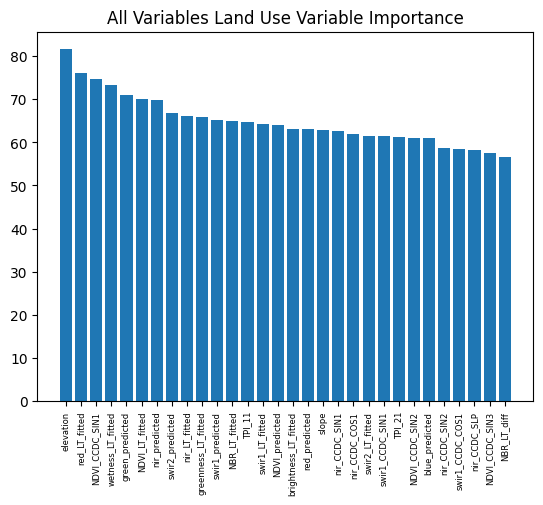

Adding layer: Land Use All Variables
Top 30 Variables Land Use OOB Accuracy: 0.9937589328251548


,Agriculture,Developed,Forest,Non-Forest Wetland,Other,Rangeland or Pasture,Producers Accuracy
Agriculture,636,0,0,0,0,0,100
Developed,0,3810,0,0,0,0,100
Forest,0,0,11823,0,0,0,100
Non-Forest Wetland,0,0,1,997,1,0,99
Other,0,0,0,0,815,0,100
Rangeland or Pasture,0,0,1,0,0,2906,99
Consumers Accuracy,100,100,99,100,99,100,99


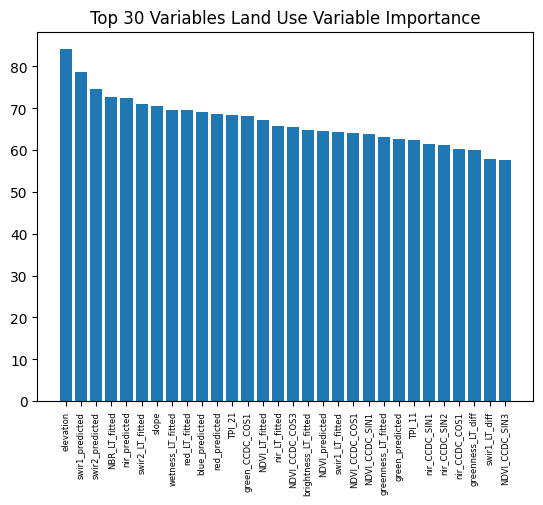

Adding layer: Land Use Top 30
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [08/Aug/2023 00:17:49] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [96]:
# Not let's train and apply a RandomForest model for Land Use
Map.clearMap()
# Set up RF model using all variables
rf_lu = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

rf_lu = rf_lu.train(training_data, reference_field_dict['Land_Use']['field']+'_Code', predictor_field_names)#['NBR_LT_fitted'])

importance = getModelInfo(rf_lu, lcms_viz_dict['Land_Use_class_names'][:-1],'All Variables Land Use')
lu_predicted = predictor_stack.classify(rf_lu,'Land_Use').set(lcms_viz_dict)

Map.addLayer(lu_predicted,{'autoViz':True},'Land Use All Variables')

# importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
rf_lu = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
lu_predictor_field_names =  list(importance.keys())
rf_lu = rf_lu.train(training_data, reference_field_dict['Land_Use']['field']+'_Code',lu_predictor_field_names)#['NBR_LT_fitted'])
# importance = rf_lc.explain().get('importance').getInfo()
getModelInfo(rf_lu, lcms_viz_dict['Land_Use_class_names'][:-1],f'Top {top_n_variables} Variables Land Use')
# var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


lu_predicted = predictor_stack.classify(rf_lu,'Land_Use').set(lcms_viz_dict)
# # print(lc_predicted.bandNames().getInfo())
Map.addLayer(lu_predicted,{'autoViz':True},f'Land Use Top {top_n_variables}')
Map.turnOnInspector()
Map.view()

# Map.clearMap()
# nTrees = 2
# seed = 999
# rf_lu = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# rf_lu = rf_lc.train(training_data, reference_field_dict['Land_Use']['field']+'_Code', ['NBR_LT_fitted'])
# # print(rf_lc.schema().getInfo())

# lu_predicted = extractionStack.classify(rf_lu,'Land_Use').set(lcms_viz_dict)
# # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lu_predicted,{'autoViz':True},'Land Use')
# Map.turnOnInspector()
# Map.view()

In [103]:
# Change is handled differently
# Since change is a rare class, models are not confident on all but the most severe change
# Therefore we model each change class separately
change_fields = reference_field_dict['Change']['fields']

for change_field in change_fields:
    n = training_data.filter(ee.Filter.eq(change_field,1))
    print(change_field,n.size().getInfo())

training_data.first().getInfo()

Slow Loss 0
Fast Loss 0
Gain 0


{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-64.78490580239071, 18.32868451098288]},
 'id': '0_00000000000000000001',
 'properties': {'BARREN': 0,
  'BARREN-GRA': 0,
  'BARREN-IMP': 0,
  'BARREN-SHR': 0,
  'BARREN-TRE': 1,
  'BARREN-TS': 0,
  'CHANGE_DUR': 2,
  'COMMENTS': '',
  'CP': 'Stable',
  'CP_NOTES': '',
  'DOM_LC': 'Barren',
  'DOM_LU': 'Forest',
  'DOM_LU_Code': 3,
  'DOM_LU_EL': '',
  'DOM_SEC_LC': 'BARREN-TRE',
  'DOM_SEC_LC_Code': 5,
  'GRASS': 0,
  'GRASS-SHRU': 0,
  'GRASS-TREE': 0,
  'GRASS-TS': 0,
  'IMPERVIOUS': 0,
  'INTERP': 48,
  'JULIANDAY': 135,
  'LAST_MODIF': '6/22/2021 12:06',
  'NBR_LT_diff': -0.006684624368081889,
  'NBR_LT_dur': 24,
  'NBR_LT_fitted': 0.5767692985806379,
  'NBR_LT_mag': -0.010026936552122834,
  'NBR_LT_slope': -0.00041778902300511805,
  'NDVI_CCDC_COS1': 0.057901283742523624,
  'NDVI_CCDC_COS2': 0.007792101065656297,
  'NDVI_CCDC_COS3': 0.017079822551271356,
  'NDVI_CCDC_INTP': -10.289777575057801,
  'NDVI_CCDC_SIN1

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists


,type,id,geometry.type,geometry.coordinates,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,...,swir2_LT_mag,swir2_LT_slope,swir2_fitSlope,swir2_predicted,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
0,Feature,0_00000000000000000001,Point,"[-64.78490580239071, 18.32868451098288]",0,0,0,0,1,0,...,0.001574,0.000063,-0.000067,0.096829,-0.017791,38,-0.048918,-0.042253,-0.001112,2000.252075
1,Feature,0_00000000000000000002,Point,"[-66.70373279040638, 18.011111793057527]",0,0,0,0,1,0,...,0.086700,0.005419,-0.008767,0.168229,0.135325,1,-0.144873,0.135325,0.135325,2000.252075
2,Feature,0_00000000000000000004,Point,"[-66.9880049416646, 17.99814918629516]",0,0,0,0,0,0,...,-0.031124,-0.001153,0.001665,0.151268,0.017487,3,-0.122488,0.052460,0.017487,2000.252075
3,Feature,0_00000000000000000007,Point,"[-66.1090893694241, 18.33875316116157]",0,0,0,0,0,0,...,0.078610,0.002069,0.000242,0.141465,-0.030306,38,-0.104347,-0.071976,-0.001894,2000.252075
4,Feature,0_00000000000000000008,Point,"[-66.87784730924028, 18.00531050258699]",0,0,0,0,0,0,...,-0.032089,-0.001188,0.000071,0.131075,-0.003836,24,-0.092475,-0.046029,-0.001918,2000.252075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20985,Feature,20_000000000000000003bb,Point,"[-66.30744802068558, 18.146066486440066]",0,0,0,0,0,0,...,0.038424,0.005489,0.000000,0.096893,-0.034774,8,-0.119835,-0.046366,-0.005796,2020.252075
20986,Feature,20_000000000000000003c6,Point,"[-66.48076436043094, 18.37840794682986]",0,0,0,0,0,0,...,-0.022253,-0.001171,0.000000,0.139035,0.014588,38,-0.081403,0.015398,0.000405,2020.252075
20987,Feature,20_000000000000000003d6,Point,"[-66.97177827293112, 17.990492909786393]",0,0,0,0,0,0,...,-0.037104,-0.009276,0.000000,0.067169,-0.029875,38,-0.065902,-0.031535,-0.000830,2020.252075
20988,Feature,20_000000000000000003d9,Point,"[-67.01755986344685, 18.0568309561585]",0,0,0,0,0,0,...,-0.015885,-0.000418,0.000000,0.075907,0.019723,38,-0.063670,0.020818,0.000548,2020.252075


0.9755121486422106


NBR_LT_fitted           0.052793
red_LT_fitted           0.042257
green_predicted         0.035995
NDVI_predicted          0.032932
wetness_LT_fitted       0.031978
red_predicted           0.030937
blue_predicted          0.024828
swir1_predicted         0.024540
swir2_LT_fitted         0.023094
swir1_LT_fitted         0.021389
swir2_predicted         0.020883
NDVI_LT_fitted          0.020106
elevation               0.019220
slope                   0.014440
NDVI_CCDC_COS1          0.013876
nir_LT_fitted           0.013861
nir_predicted           0.013473
greenness_LT_fitted     0.013040
NDVI_CCDC_SIN1          0.010551
swir1_CCDC_SIN1         0.010270
NDVI_LT_mag             0.010127
brightness_LT_fitted    0.009957
nir_CCDC_SIN1           0.009787
nir_CCDC_COS1           0.009763
red_CCDC_SIN1           0.009123
NDVI_CCDC_COS2          0.008820
TPI_21                  0.008635
swir2_CCDC_SIN1         0.008572
nir_CCDC_SIN2           0.008423
green_CCDC_COS1         0.008002
dtype: flo

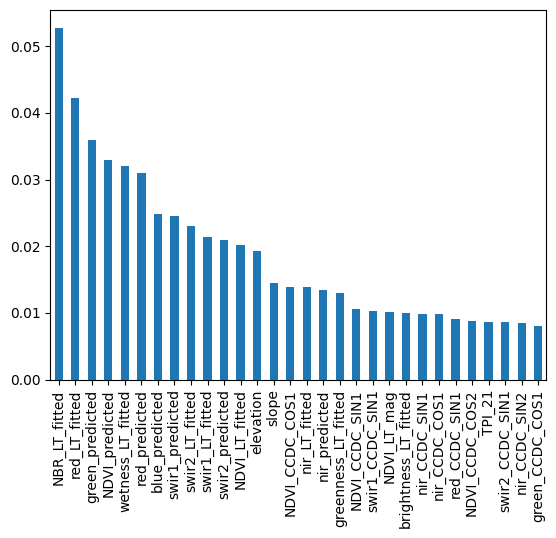

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

import os

# Specify a local location to store LCMS training data \
local_training_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_training_data_folder,'timeSync_training_table.csv')

seed = 999
nTrees = 50
if not os.path.exists(local_training_data_folder):os.makedirs(local_training_data_folder)

g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)
training_df = pd.read_csv(local_training_csv)
X = training_df[predictor_field_names]
y = training_df[reference_field_dict['Land_Cover']['field']+'_Code']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
display(training_df)
rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
# print(training_df[reference_field_dict['Land_Cover']['field']+'_Code'])
rf.fit(X,y)
# print(clf)
oob_acc = rf.oob_score_
print(oob_acc)
# print(clf.classes_)
# print(clf.feature_importances_)
feature_importances = pd.Series(rf.feature_importances_, index=predictor_field_names).sort_values(ascending=False).iloc[:30]
display(feature_importances)
# Plot a simple bar chart
feature_importances.plot.bar(rot=90);
# importance_dict = dict(zip(predictor_field_names,clf.feature_importances_))
# var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = top_n_variables,descending = True)
# display(training_df[['wetness_LT_fitted','NBR_LT_fitted']])

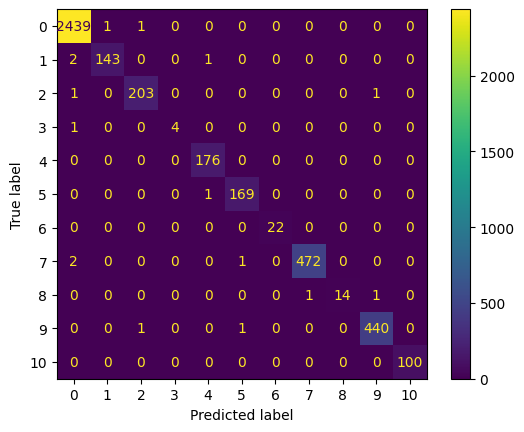

In [66]:
# Generate predictions with the best model
y_pred = rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [76]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X, y, cv=10,scoring = 'balanced_accuracy')
scores
print("%0.2f balanced accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 balanced accuracy with a standard deviation of 0.04


NBR_LT_fitted           0.050181
red_LT_fitted           0.047087
green_predicted         0.036395
wetness_LT_fitted       0.036058
red_predicted           0.028687
NDVI_predicted          0.028161
blue_predicted          0.028139
swir1_predicted         0.027217
swir2_LT_fitted         0.022334
swir2_predicted         0.020669
NDVI_LT_fitted          0.020262
elevation               0.018187
swir1_LT_fitted         0.016881
greenness_LT_fitted     0.016566
slope                   0.013727
nir_LT_fitted           0.013403
brightness_LT_fitted    0.012256
nir_CCDC_COS1           0.012066
nir_predicted           0.012056
NDVI_CCDC_COS1          0.011387
red_CCDC_SIN1           0.010539
NDVI_CCDC_SIN1          0.009807
NDVI_LT_mag             0.009654
swir1_CCDC_SIN1         0.009608
nir_CCDC_SIN1           0.009445
NDVI_CCDC_SIN2          0.009299
swir2_CCDC_SIN1         0.009106
hillshade               0.008877
green_CCDC_COS1         0.008858
nir_CCDC_SIN2           0.008747
dtype: flo

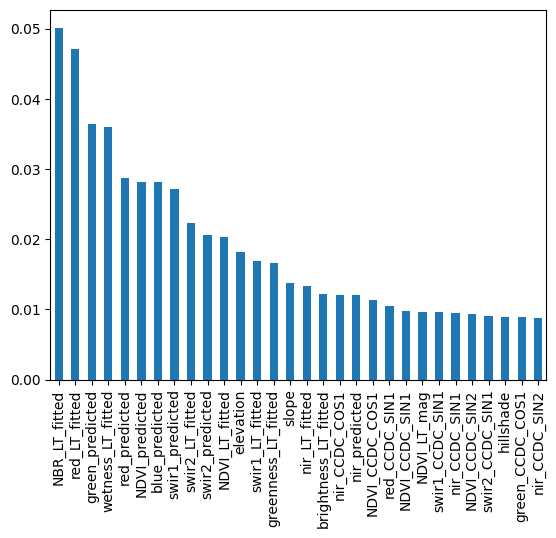

In [79]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_transformed = scaler.transform(X_train)
clf = rf.fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

feature_importances = pd.Series(clf.feature_importances_, index=predictor_field_names).sort_values(ascending=False).iloc[:30]
display(feature_importances)
# Plot a simple bar chart
feature_importances.plot.bar(rot=90);

In [83]:
Map.clearMap()
# Now lets export predicted assets
# First, we'll set up the study area and a tile to export across

studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary_buff2mile')

# Set the size (in meters) of the tiles
tileSize = 60000

# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None
projection = ee.Projection(crs,transform)

# Get the grid
grid = studyArea.geometry().coveringGrid(projection.atScale(tileSize))
Map.addLayer(grid,{},'Tile Grid {}m'.format(tileSize))

Map.centerObject(studyArea)
Map.view()

Adding layer: Tile Grid 60000m
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1234/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://23dcc4ff89e513fb-dot-us-west3.notebooks.googleusercontent.com/proxy/1234/geeView/?accessToken=None


127.0.0.1 - - [07/Aug/2023 23:50:53] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


In [ ]:
# Set up params
nTrees = 